In [1]:
try:
    import google.colab  # noqa: F401

    %pip install -q dataeval torchvision
except Exception:
    pass

In [2]:
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import torch
from maite_datasets.image_classification import CIFAR10, MNIST

import dataeval
from dataeval import Embeddings
from dataeval.selection import ClassFilter, Limit, Select, Shuffle
from dataeval.shift import OODKNeighbors, OODReconstruction, OODReconstructionConfig
from dataeval.utils.models import AE, VAE, GMMDensityNet
from dataeval.utils.preprocessing import rescale, resize, to_canonical_grayscale

# Set random seeds for reproducibility
dataeval.config.set_seed(173, all_generators=True)

# Set default batch size
dataeval.config.set_batch_size(64)

# Set default torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def normalize(x):
    return x.astype(np.float32) / 255.0


in_dist_digits = [0, 1, 2, 3, 4, 5, 6, 7]
out_of_dist_digits = [8, 9]


mnist_train = Select(
    MNIST("./data", image_set="train", download=True, transforms=normalize),
    selections=[Shuffle(), Limit(10000), ClassFilter(in_dist_digits)],
)
mnist_test_in = Select(
    MNIST("./data", image_set="test", download=True, transforms=normalize),
    selections=[Shuffle(), Limit(1000), ClassFilter(in_dist_digits)],
)
mnist_test_ood = Select(
    MNIST("./data", image_set="test", download=True, transforms=normalize),
    selections=[Shuffle(), Limit(1000), ClassFilter(out_of_dist_digits)],
)

print(f"Training set size: {len(mnist_train)}")
print(f"Test set size: {len(mnist_test_in)}")
print(f"Test set size: {len(mnist_test_ood)}")

# Set the input shape (MNIST images are 28x28 grayscale)
input_shape = (1, 28, 28)

Training set size: 10000
Test set size: 1000
Test set size: 1000


In [4]:
# Extract data and labels from prefiltered datasets
def extract_data_labels(dataset):
    """Extract images and labels from a dataset."""
    data, labels = [], []

    for img, label_probs, _ in dataset:
        label = np.argmax(label_probs)
        data.append(img)
        labels.append(label)

    return np.stack(data), np.asarray(labels)


# Extract training and test data (already filtered for correct classes)
train_in, train_in_labels = extract_data_labels(mnist_train)
test_in, test_in_labels = extract_data_labels(mnist_test_in)
test_ood, test_ood_labels = extract_data_labels(mnist_test_ood)

print(f"Training in-distribution: {train_in.shape}")
print(f"Test in-distribution: {test_in.shape}")
print(f"Test out-of-distribution: {test_ood.shape}")

Training in-distribution: (10000, 1, 28, 28)
Test in-distribution: (1000, 1, 28, 28)
Test out-of-distribution: (1000, 1, 28, 28)


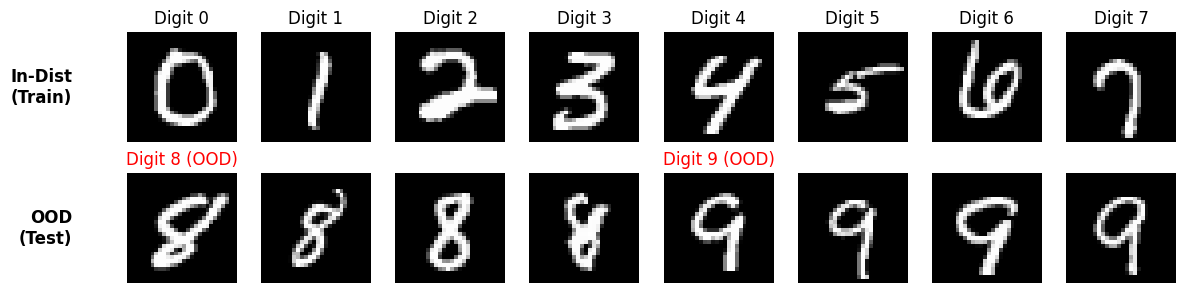

In [5]:
# Visualize some in-distribution and OOD samples
fig, axes = plt.subplots(2, 8, figsize=(12, 3))

# Show in-distribution samples (0-7) - one of each digit
for digit in range(8):
    # Find the first occurrence of this digit
    idx = (train_in_labels == digit).nonzero()[0][0]
    axes[0, digit].imshow(train_in[idx].squeeze(), cmap="gray")
    axes[0, digit].axis("off")
    axes[0, digit].set_title(f"Digit {digit}")

# Show OOD samples (8-9) - 4 of each
for i in range(8):
    digit = 8 if i < 4 else 9
    idx = (test_ood_labels == digit).nonzero()[0][(i % 4) * 50]
    axes[1, i].imshow(test_ood[idx].squeeze(), cmap="gray")
    axes[1, i].axis("off")
    if i % 4 == 0:
        axes[1, i].set_title(f"Digit {digit} (OOD)", color="red")

axes_text_kwargs = {"ha": "right", "va": "center", "fontsize": 12, "fontweight": "bold"}
axes[0, 0].text(-0.5, 0.5, "In-Dist\n(Train)", transform=axes[0, 0].transAxes, **axes_text_kwargs)
axes[1, 0].text(-0.5, 0.5, "OOD\n(Test)", transform=axes[1, 0].transAxes, **axes_text_kwargs)

plt.tight_layout()
plt.show()

In [6]:
# Define a simple CNN for learning embeddings
class EmbeddingNet(torch.nn.Module):
    """Simple CNN that learns embeddings for digit classification."""

    def __init__(self, embedding_dim=64):
        super().__init__()
        self.embedding_dim = embedding_dim

        # Convolutional layers
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),  # 28x28 -> 14x14
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),  # 14x14 -> 7x7
        )

        # Embedding layer
        self.embedding = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(64 * 7 * 7, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, embedding_dim),
        )

        # Classification head (for training only)
        self.classifier = torch.nn.Linear(embedding_dim, 8)  # 8 digit classes (0-7)

    def forward(self, x, return_embedding=False):
        """Forward pass. Returns embeddings if return_embedding=True, else logits."""
        emb = self.embedding(self.conv_layers(x))
        return emb if return_embedding else self.classifier(emb)

In [7]:
# Create and train the embedding model
embedding_model = EmbeddingNet(embedding_dim=64).to(device)
optimizer = torch.optim.Adam(embedding_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

print("Training embedding model for digit classification...")
print(f"Embedding dimension: {embedding_model.embedding_dim}")

# Train for a few epochs
num_epochs = 3
batch_size = 256

for epoch in range(num_epochs):
    embedding_model.train()
    total_loss, correct, total = 0, 0, 0

    # Create batches
    num_batches = len(train_in) // batch_size
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        batch_imgs = torch.as_tensor(train_in[start_idx:end_idx], device=device)
        batch_labels = torch.as_tensor(train_in_labels[start_idx:end_idx], device=device)

        # Forward pass
        optimizer.zero_grad()
        logits = embedding_model(batch_imgs)
        loss = criterion(logits, batch_labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    avg_loss = total_loss / num_batches
    accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("✓ Embedding model trained!")

Training embedding model for digit classification...
Embedding dimension: 64


Epoch 1/3 - Loss: 0.9003, Accuracy: 72.40%


Epoch 2/3 - Loss: 0.2186, Accuracy: 93.19%


Epoch 3/3 - Loss: 0.1354, Accuracy: 95.88%
✓ Embedding model trained!


In [8]:
# Get embeddings for all datasets
print("Extracting embeddings...")
train_in_emb = Embeddings(train_in, model=embedding_model)
test_in_emb = Embeddings(test_in, model=embedding_model)
test_ood_emb = Embeddings(test_ood, model=embedding_model)

print(f"Training embeddings shape: {train_in_emb.shape}")
print(f"Test in-dist embeddings shape: {test_in_emb.shape}")
print(f"Test OOD embeddings shape: {test_ood_emb.shape}")

Extracting embeddings...
Training embeddings shape: (10000, 8)
Test in-dist embeddings shape: (1000, 8)
Test OOD embeddings shape: (1000, 8)


In [9]:
# Create KNN detector with learned embeddings
ood_knn = OODKNeighbors(k=10, distance_metric="cosine")

print("\nFitting KNN detector with learned embeddings...")
ood_knn.fit(train_in_emb, threshold_perc=95.0)
print("Done!")


Fitting KNN detector with learned embeddings...


Done!


In [10]:
# Get predictions with learned embeddings
knn_result_in = ood_knn.predict(test_in_emb)
knn_result_ood = ood_knn.predict(test_ood_emb)

# Calculate detection accuracy
in_acc_knn = 100 * (1 - knn_result_in.is_ood.mean())
ood_rate_knn = 100 * knn_result_ood.is_ood.mean()

print("\n--- KNN (Embeddings) Results ---")
print(f"In-distribution correctly identified: {in_acc_knn:.1f}%")
print(f"OOD samples detected: {ood_rate_knn:.1f}%")
print(f"Average score (in-dist): {knn_result_in.instance_score.mean():.4f}")
print(f"Average score (OOD): {knn_result_ood.instance_score.mean():.4f}")


--- KNN (Embeddings) Results ---
In-distribution correctly identified: 95.3%
OOD samples detected: 37.1%
Average score (in-dist): 0.0150
Average score (OOD): 0.0482


In [11]:
# Create and configure the autoencoder
ae_model = AE(input_shape=input_shape)

# Configure training parameters
config = OODReconstructionConfig(
    epochs=3,
    batch_size=64,
    threshold_perc=95.0,  # 95% of training data considered normal
)

# Initialize OOD detector
ood_ae = OODReconstruction(ae_model, device=device, config=config)

print("Training Standard Autoencoder...")
print(f"Model type detected: {ood_ae.model_type}")
print(f"Using GMM: {ood_ae.use_gmm}")

Training Standard Autoencoder...
Model type detected: ae
Using GMM: False


In [12]:
# Train the model on in-distribution data
ood_ae.fit(train_in)

In [13]:
# Get predictions
ae_result_in = ood_ae.predict(test_in)
ae_result_ood = ood_ae.predict(test_ood)

# Calculate detection accuracy
in_acc_ae = 100 * (1 - ae_result_in.is_ood.mean())
ood_rate_ae = 100 * ae_result_ood.is_ood.mean()

print("\n--- Standard AE Results ---")
print(f"In-distribution correctly identified: {in_acc_ae:.1f}%")
print(f"OOD samples detected: {ood_rate_ae:.1f}%")
print(f"Average score (in-dist): {ae_result_in.instance_score.mean():.4f}")
print(f"Average score (OOD): {ae_result_ood.instance_score.mean():.4f}")

# Validation: Check if OOD scores are higher than in-dist scores
score_separation = ae_result_ood.instance_score.mean() - ae_result_in.instance_score.mean()
print(f"\nScore separation (OOD - In-Dist): {score_separation:.4f}")
if score_separation > 0:
    print("✓ Expected: OOD samples have higher scores than in-distribution samples")
else:
    print("⚠ Warning: OOD scores should be higher than in-distribution scores")

# Check if we're near the target threshold
if 90 <= in_acc_ae <= 98:
    print(f"✓ Expected: ~95% of in-distribution samples correctly identified (got {in_acc_ae:.1f}%)")
else:
    print(f"⚠ Note: Expected ~95% in-dist accuracy, got {in_acc_ae:.1f}%")


--- Standard AE Results ---
In-distribution correctly identified: 96.6%
OOD samples detected: 27.4%
Average score (in-dist): 0.0100
Average score (OOD): 0.0157

Score separation (OOD - In-Dist): 0.0057
✓ Expected: OOD samples have higher scores than in-distribution samples
✓ Expected: ~95% of in-distribution samples correctly identified (got 96.6%)


In [14]:
# Create and configure the VAE
vae_model = VAE(input_shape=input_shape)

# Initialize OOD detector (auto-detects as VAE)
ood_vae = OODReconstruction(vae_model, device=device, config=config)

print("Training Variational Autoencoder...")
print(f"Model type detected: {ood_vae.model_type}")
print(f"Using GMM: {ood_vae.use_gmm}")

Training Variational Autoencoder...
Model type detected: vae
Using GMM: False


In [15]:
# Train the VAE
ood_vae.fit(train_in)

In [16]:
# Evaluate VAE performance
vae_result_in = ood_vae.predict(test_in)
vae_result_ood = ood_vae.predict(test_ood)

in_acc_vae = 100 * (1 - vae_result_in.is_ood.mean())
ood_rate_vae = 100 * vae_result_ood.is_ood.mean()

print("\n--- VAE Results ---")
print(f"In-distribution correctly identified: {in_acc_vae:.1f}%")
print(f"OOD samples detected: {ood_rate_vae:.1f}%")
print(f"Average score (in-dist): {vae_result_in.instance_score.mean():.4f}")
print(f"Average score (OOD): {vae_result_ood.instance_score.mean():.4f}")


--- VAE Results ---
In-distribution correctly identified: 94.0%
OOD samples detected: 4.8%
Average score (in-dist): 0.1210
Average score (OOD): 0.1258


In [17]:
# Create AE with GMM density network
# The latent dimension is auto-computed by AE
ae_model_gmm = AE(input_shape=input_shape)
latent_dim = cast(int, ae_model_gmm.encoder.flatten[1].out_features)

# Create GMM density network with 3 components
gmm_density_net = GMMDensityNet(latent_dim=latent_dim, n_gmm=3)
ae_model_gmm.gmm_density_net = gmm_density_net

# Configure training parameters
config_gmm = OODReconstructionConfig(
    epochs=3,
    batch_size=64,
    threshold_perc=95.0,  # 95% of training data considered normal
    gmm_weight=0.7,  # For GMM models: balance reconstruction (30%) and GMM energy (70%)
    gmm_score_mode="standardized",  # Use z-score normalization for score fusion
)

# Initialize OOD detector (auto-detects GMM usage)
ood_ae_gmm = OODReconstruction(ae_model_gmm, device=device, config=config_gmm)

print("Training Autoencoder with GMM...")
print(f"Model type detected: {ood_ae_gmm.model_type}")
print(f"Using GMM: {ood_ae_gmm.use_gmm}")
print(f"Latent dimension: {latent_dim}")
print(f"Number of GMM components: {gmm_density_net.n_gmm}")

Training Autoencoder with GMM...
Model type detected: ae
Using GMM: True
Latent dimension: 256
Number of GMM components: 3


In [18]:
# Train the AE+GMM model
ood_ae_gmm.fit(train_in)

In [19]:
# Evaluate AE+GMM performance
ae_gmm_result_in = ood_ae_gmm.predict(test_in)
ae_gmm_result_ood = ood_ae_gmm.predict(test_ood)

in_acc_ae_gmm = 100 * (1 - ae_gmm_result_in.is_ood.mean())
ood_rate_ae_gmm = 100 * ae_gmm_result_ood.is_ood.mean()

print("\n--- AE + GMM Results ---")
print(f"In-distribution correctly identified: {in_acc_ae_gmm:.1f}%")
print(f"OOD samples detected: {ood_rate_ae_gmm:.1f}%")
print(f"Average score (in-dist): {ae_gmm_result_in.instance_score.mean():.4f}")
print(f"Average score (OOD): {ae_gmm_result_ood.instance_score.mean():.4f}")


--- AE + GMM Results ---
In-distribution correctly identified: 95.1%
OOD samples detected: 13.1%
Average score (in-dist): -0.0205
Average score (OOD): 0.5710


In [20]:
# Create VAE with GMM density network
vae_model_gmm = VAE(input_shape=input_shape)
vae_latent_dim = vae_model_gmm.latent_dim

# Create GMM density network
gmm_density_net_vae = GMMDensityNet(latent_dim=vae_latent_dim, n_gmm=3)
vae_model_gmm.gmm_density_net = gmm_density_net_vae

# Initialize OOD detector
ood_vae_gmm = OODReconstruction(vae_model_gmm, device=device, config=config_gmm)

print("Training VAE with GMM...")
print(f"Model type detected: {ood_vae_gmm.model_type}")
print(f"Using GMM: {ood_vae_gmm.use_gmm}")
print(f"Latent dimension: {vae_latent_dim}")
print(f"Number of GMM components: {gmm_density_net_vae.n_gmm}")

Training VAE with GMM...
Model type detected: vae
Using GMM: True
Latent dimension: 256
Number of GMM components: 3


In [21]:
# Train the VAE+GMM model
ood_vae_gmm.fit(train_in)

In [22]:
# Evaluate VAE+GMM performance
vae_gmm_result_in = ood_vae_gmm.predict(test_in)
vae_gmm_result_ood = ood_vae_gmm.predict(test_ood)

in_acc_vae_gmm = 100 * (1 - vae_gmm_result_in.is_ood.mean())
ood_rate_vae_gmm = 100 * vae_gmm_result_ood.is_ood.mean()

print("\n--- VAE + GMM Results ---")
print(f"In-distribution correctly identified: {in_acc_vae_gmm:.1f}%")
print(f"OOD samples detected: {ood_rate_vae_gmm:.1f}%")
print(f"Average score (in-dist): {vae_gmm_result_in.instance_score.mean():.4f}")
print(f"Average score (OOD): {vae_gmm_result_ood.instance_score.mean():.4f}")


--- VAE + GMM Results ---
In-distribution correctly identified: 94.6%
OOD samples detected: 15.8%
Average score (in-dist): -0.0045
Average score (OOD): 0.6843


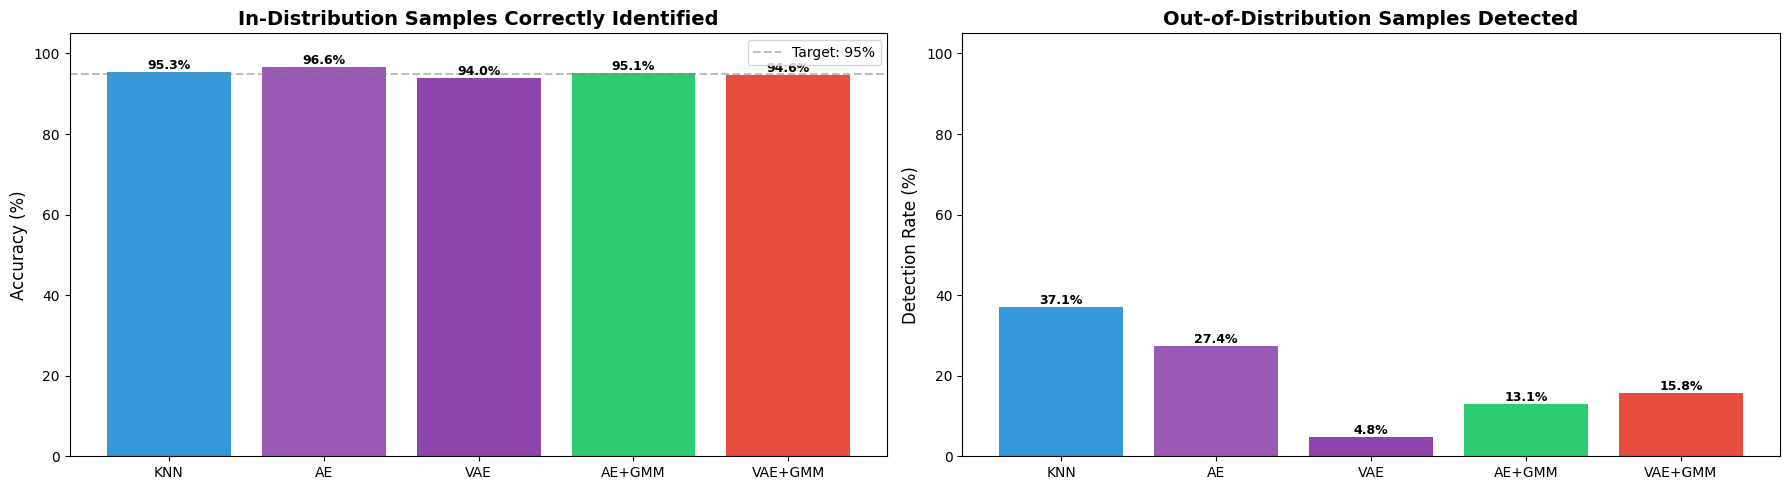

In [23]:
# Summary comparison
methods = ["KNN", "AE", "VAE", "AE+GMM", "VAE+GMM"]
in_dist_acc = [in_acc_knn, in_acc_ae, in_acc_vae, in_acc_ae_gmm, in_acc_vae_gmm]
ood_detect = [ood_rate_knn, ood_rate_ae, ood_rate_vae, ood_rate_ae_gmm, ood_rate_vae_gmm]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# Plot in-distribution accuracy
colors = ["#3498db", "#9b59b6", "#8e44ad", "#2ecc71", "#e74c3c", "#f39c12"]
bars1 = ax1.bar(methods, in_dist_acc, color=colors)
ax1.set_ylabel("Accuracy (%)", fontsize=12)
ax1.set_title("In-Distribution Samples Correctly Identified", fontsize=14, fontweight="bold")
ax1.set_ylim([0, 105])
ax1.axhline(y=95, color="gray", linestyle="--", alpha=0.5, label="Target: 95%")
ax1.legend()
ax1.tick_params(axis="x", rotation=0)
text_kwargs = {"ha": "center", "va": "bottom", "fontsize": 9, "fontweight": "bold"}
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.1f}%", **text_kwargs)

# Plot OOD detection rate
bars2 = ax2.bar(methods, ood_detect, color=colors)
ax2.set_ylabel("Detection Rate (%)", fontsize=12)
ax2.set_title("Out-of-Distribution Samples Detected", fontsize=14, fontweight="bold")
ax2.set_ylim([0, 105])
ax2.tick_params(axis="x", rotation=0)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.1f}%", **text_kwargs)

plt.tight_layout()
plt.show()

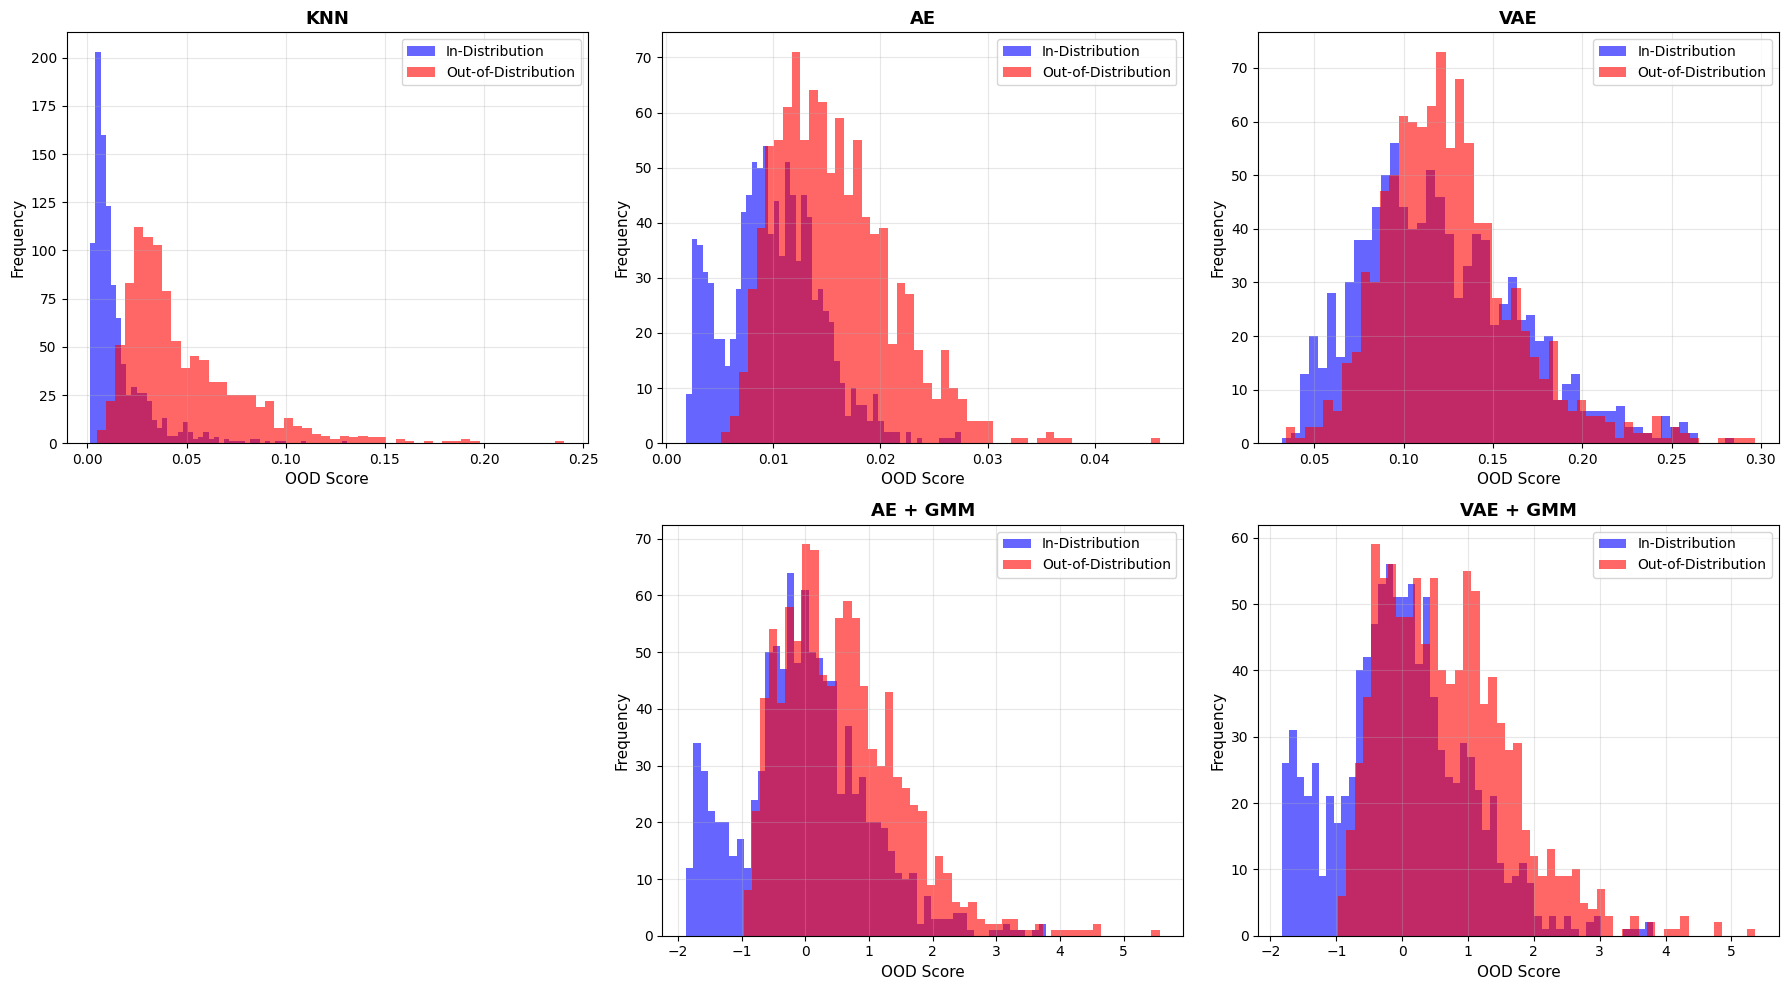

In [24]:
# Visualize OOD score distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
results = [
    (knn_result_in, knn_result_ood, "KNN"),
    (ae_result_in, ae_result_ood, "AE"),
    (vae_result_in, vae_result_ood, "VAE"),
    None,  # Skip this subplot
    (ae_gmm_result_in, ae_gmm_result_ood, "AE + GMM"),
    (vae_gmm_result_in, vae_gmm_result_ood, "VAE + GMM"),
]

for idx, result in enumerate(results):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]

    if result is None:
        ax.set_visible(False)
        continue

    result_in, result_ood, title = result

    # Plot histograms
    ax.hist(result_in.instance_score, bins=50, alpha=0.6, label="In-Distribution", color="blue")
    ax.hist(result_ood.instance_score, bins=50, alpha=0.6, label="Out-of-Distribution", color="red")

    ax.set_xlabel("OOD Score", fontsize=11)
    ax.set_ylabel("Frequency", fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Helper function to get reconstructions
def get_reconstructions(model, data, device):
    """Get reconstructions from a model."""
    # Ensure model is on the correct device
    model.model.to(device)
    model.model.eval()
    with torch.no_grad():
        data_tensor = torch.from_numpy(data).float().to(device)
        output = model.model(data_tensor)
        # Handle different output formats (AE vs VAE vs GMM)
        reconstruction = output[0] if isinstance(output, tuple) else output
        return reconstruction.cpu().numpy()


# Get a few examples
n_examples = 4
example_in = test_in[:n_examples]
example_ood = test_ood[:n_examples]

# Get reconstructions from all models
recon_ae_in = get_reconstructions(ood_ae, example_in, device)
recon_ae_ood = get_reconstructions(ood_ae, example_ood, device)

recon_vae_gmm_in = get_reconstructions(ood_vae_gmm, example_in, device)
recon_vae_gmm_ood = get_reconstructions(ood_vae_gmm, example_ood, device)

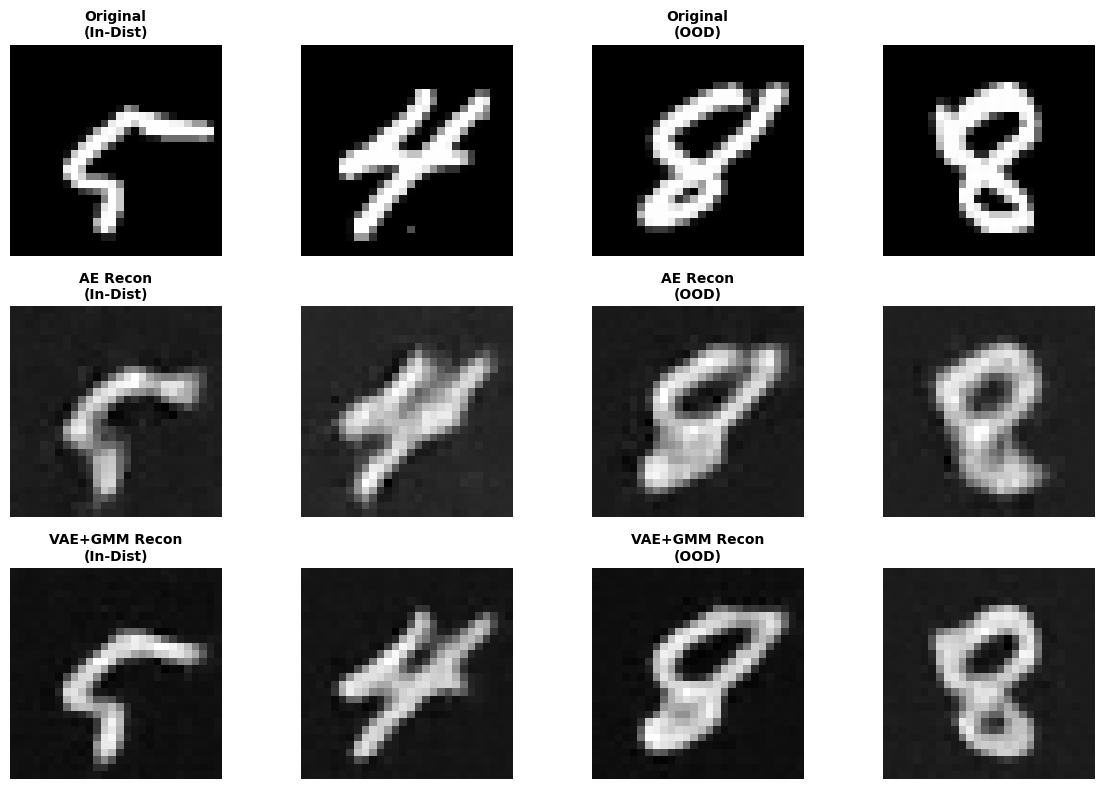

In [26]:
# Visualize reconstructions
fig, axes = plt.subplots(3, n_examples, figsize=(12, 8))

# Render images - split n_examples in half for in-dist and OOD
n_half = n_examples // 2
titles = ["Original", "AE Recon", "VAE+GMM Recon"]
examples_in = [example_in, recon_ae_in, recon_vae_gmm_in]
examples_ood = [example_ood, recon_ae_ood, recon_vae_gmm_ood]

for j in range(3):
    axes[j, 0].set_title(f"{titles[j]}\n(In-Dist)", fontsize=10, fontweight="bold")
    axes[j, n_half].set_title(f"{titles[j]}\n(OOD)", fontsize=10, fontweight="bold")
    for i in range(n_half):
        # In-dist samples (left half)
        axes[j, i].imshow(examples_in[j][i].squeeze(), cmap="gray")
        axes[j, i].axis("off")
        # OOD samples (right half)
        axes[j, i + n_half].imshow(examples_ood[j][i].squeeze(), cmap="gray")
        axes[j, i + n_half].axis("off")

plt.tight_layout()
plt.show()

In [27]:
# Create different OOD scenarios

# Scenario 1: Easy OOD - CIFAR10 (completely different domain: natural images vs digits)
# Load CIFAR10 and convert to match MNIST format
cifar_dataset = CIFAR10("./data", image_set="test", download=True)
easy_ood_list = []
for i in range(500):
    img = cifar_dataset[i][0]
    img_gray = resize(to_canonical_grayscale(rescale(img, 8)), 28)[np.newaxis, :]
    easy_ood_list.append(normalize(img_gray))
easy_ood = np.stack(easy_ood_list)

# Scenario 2: Medium OOD - Rotated digits (same domain, different transformation)
medium_ood = np.rot90(test_in[:500], k=1, axes=(2, 3)).copy()

# Scenario 3: Hard OOD - Digits 8-9 (already created as test_ood_subset)
hard_ood = test_ood

# Get embeddings for all OOD scenarios
easy_ood_emb = Embeddings(easy_ood, model=embedding_model)
medium_ood_emb = Embeddings(medium_ood, model=embedding_model)
hard_ood_emb = Embeddings(hard_ood, model=embedding_model)

print("Created three OOD scenarios:")
print(f"1. Easy (CIFAR10 → grayscale): {easy_ood.shape}")
print(f"2. Medium (Rotated digits): {medium_ood.shape}")
print(f"3. Hard (Digits 8-9): {hard_ood.shape}")

Created three OOD scenarios:
1. Easy (CIFAR10 → grayscale): (500, 1, 28, 28)
2. Medium (Rotated digits): (500, 1, 28, 28)
3. Hard (Digits 8-9): (1000, 1, 28, 28)


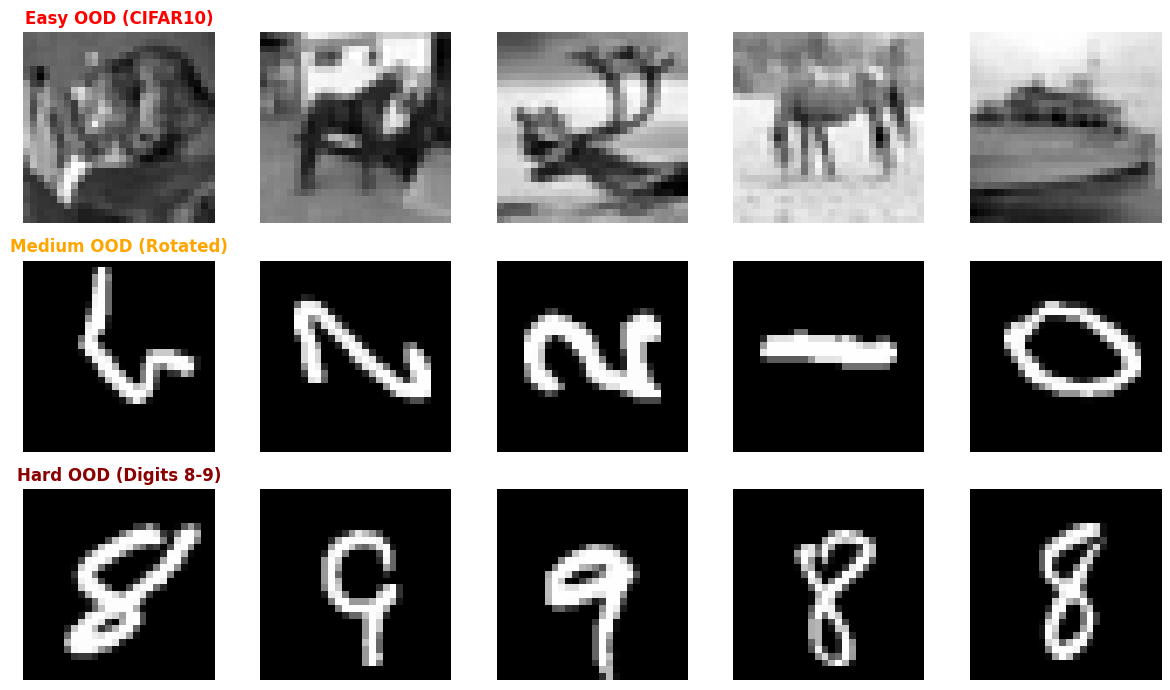

In [28]:
# Visualize the different OOD scenarios
fig, axes = plt.subplots(3, 5, figsize=(12, 7))

ood_by_scenario = [easy_ood, medium_ood, hard_ood]
ood_title = [("Easy OOD (CIFAR10)", "red"), ("Medium OOD (Rotated)", "orange"), ("Hard OOD (Digits 8-9)", "darkred")]

# Easy OOD - CIFAR10 (grayscale)
for i in range(5):
    for j in range(3):
        if i == 0:
            axes[j, 0].set_title(ood_title[j][0], fontweight="bold", color=ood_title[j][1])
        axes[j, i].imshow(ood_by_scenario[j][i * 20].squeeze(), cmap="gray")
        axes[j, i].axis("off")

plt.tight_layout()
plt.show()

In [29]:
# Evaluate all models on all three OOD scenarios
models = {"KNN": ood_knn, "AE": ood_ae, "VAE": ood_vae, "AE+GMM": ood_ae_gmm, "VAE+GMM": ood_vae_gmm}

scenarios = {
    "Easy (CIFAR10)": (easy_ood, easy_ood_emb),
    "Medium (Rotated)": (medium_ood, medium_ood_emb),
    "Hard (Digits 8-9)": (hard_ood, hard_ood_emb),
}

# Store results
results_matrix = {}

for model_name, model in models.items():
    results_matrix[model_name] = {}
    for scenario_name, (ood_data, ood_data_emb) in scenarios.items():
        # Use appropriate data format
        data_to_use = ood_data_emb if model_name == "KNN" else ood_data

        result = model.predict(data_to_use)
        detection_rate = 100 * result.is_ood.mean()
        results_matrix[model_name][scenario_name] = detection_rate

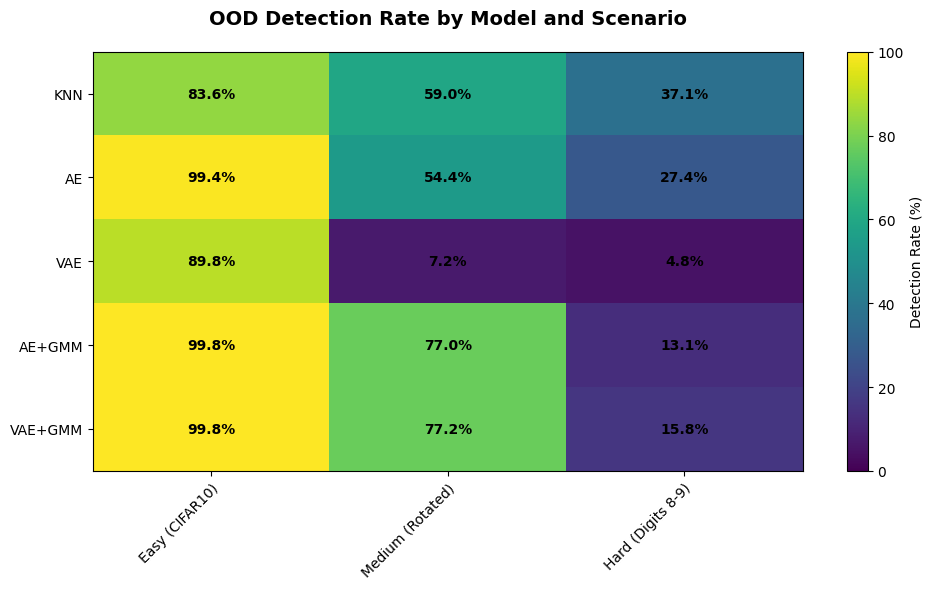

In [30]:
# Create heatmap visualization
fig, ax = plt.subplots(figsize=(10, 6))

model_names = list(results_matrix.keys())
scenario_names = list(scenarios.keys())

# Create matrix for heatmap
data = np.array([[results_matrix[model][scenario] for scenario in scenario_names] for model in model_names])

im = ax.imshow(data, cmap="viridis", aspect="auto", vmin=0, vmax=100)

# Set ticks and labels
ax.set_xticks(np.arange(len(scenario_names)))
ax.set_yticks(np.arange(len(model_names)))
ax.set_xticklabels(scenario_names)
ax.set_yticklabels(model_names)

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(len(model_names)):
    for j in range(len(scenario_names)):
        text = ax.text(j, i, f"{data[i, j]:.1f}%", ha="center", va="center", color="black", fontweight="bold")

ax.set_title("OOD Detection Rate by Model and Scenario", fontsize=14, fontweight="bold", pad=20)
fig.colorbar(im, ax=ax, label="Detection Rate (%)")

plt.tight_layout()
plt.show()